In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn import preprocessing

In [ ]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [ ]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1,
                             test_size=0.2)

for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / (len(y_train))))

In [ ]:
from sklearn.metrics import make_scorer, f1_score

pipe = Pipeline([
    ("scaler", preprocessing.StandardScaler()),
    ("svc", svm.SVC(class_weight=weight_dict))
])

param_grid = [
    # {
    #     "svc__kernel": ["linear"],
    #     "svc__C": np.logspace(0, 3.5, 25)
    # },
    {
        "svc__kernel": ["rbf"],
        "svc__C": np.logspace(0, 3.5, 25),
        "svc__gamma": ["scale", 0.01, 0.1]
    }
]

# # Set the SVM classifier
# svc = svm.SVC(class_weight=weight_dict)

# scaler = preprocessing.StandardScaler().fit(X_train)

# X_train_scaled = scaler.transform(X_train)

# Set the GridSearch. Use the f1 "weighted" score in a maker_scorer function.
wclf = GridSearchCV(pipe,
                    param_grid, 
                    # scoring=make_scorer(f1_score, average="weighted"),
                    scoring="f1_weighted",
                    verbose=3, 
                    cv=5,
                    n_jobs=-1)

# Start Training...
wclf.fit(X_train, y_train)


Fitting 5 folds for each of 75 candidates, totalling 375 fits


,estimator,Pipeline(step..._('X'): 5}))])
,param_grid,"[{'svc__C': array([1.0000...16227766e+03]), 'svc__gamma': ['scale', 0.01, ...], 'svc__kernel': ['rbf']}]"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [ ]:
final_grid_model = wclf.best_estimator_

# print(f"Kernel with the best result: {final_clf.kernel}")
# print(f"SVM information: {final_clf}")
print(final_grid_model.classes_)

['C' 'Other' 'S' 'X']


In [ ]:
# X_test_scaled = scaler.transform(X_test)

y_test_pred = final_grid_model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

print(conf_mat)

[[ 79   0   0   0]
 [  0  29   2   0]
 [  0   1 109   0]
 [  1   1   0  46]]


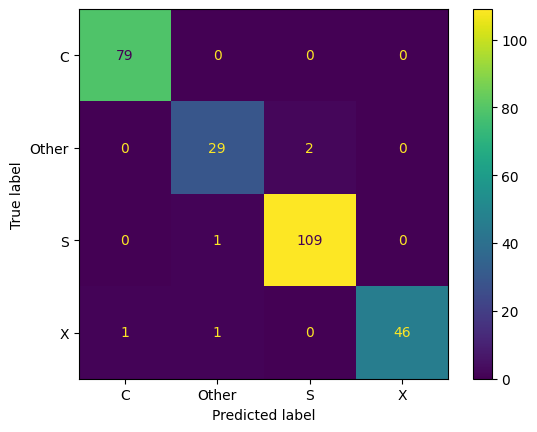

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    final_grid_model,
    X_test,
    y_test,
    values_format="d"
)

plt.show()


In [ ]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.981


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           C       0.99      1.00      0.99        79
       Other       0.94      0.94      0.94        31
           S       0.98      0.99      0.99       110
           X       1.00      0.96      0.98        48

    accuracy                           0.98       268
   macro avg       0.98      0.97      0.97       268
weighted avg       0.98      0.98      0.98       268

